# Computation Efficiency with Numpy, PyTorch, and JIT

This notebooks illustrates the computational efficiency of running linear algebra with the proper tools - such as numpy.

In [3]:
from matplotlib import pyplot as plt

def plot_times(labels, times):
    x = list(range(len(times)))
    fig, ax = plt.subplots()
    ax.grid(alpha=0.5, ls='--', which='both')
    ax.bar(x, times, log=True)
    ax.set_xticks(x, labels)
    ax.set_axisbelow(True)

Let's compute an array dot product in Python:

In [4]:
def array_dot_product(v1, v2):
    result = 0
    for v1_i, v2_i in zip(v1, v2):
        result += v1_i * v2_i
    return result

v1 = list(range(100))
v2 = [1]*100

print("v1 = {}".format(v1))
print("v2 = {}\n".format(v2))

print("v1 dot v2: {}".format(array_dot_product(v1, v2)))
print("1+2+...+99:", 99*100/2)

v1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
v2 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

v1 dot v2: 4950
1+2+...+99: 4950.0


Okay, it works, but how long does it take?

In [5]:
%timeit array_dot_product(v1, v2)

4.8 µs ± 136 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Enters numpy

Now let's try with numpy, which uses a C backend optimized for mathematical operations, alleviating the Python overhead.

In [6]:
import numpy as np

In [7]:
v1_np = np.arange(100)
v2_np = np.ones(100)
print("v1 dot v2: {}".format(v1_np.dot(v2_np)))

v1 dot v2: 4950.0


Nice, aligned with our raw Python version. Now let's check the running time.

In [8]:
%timeit v1_np.dot(v2_np)

1.11 µs ± 11.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


We can already se the difference. Numpy was roughly 6x faster than raw PyTorch for a very small array. New let's check with matrices.

In [9]:
def matrix_mul(m1, m2):
    num_rows = len(m1)
    num_columns = len(m2[0])
    internal_dim = len(m1[0])
    result = []
    for i in range(num_rows):
        new_row = []
        for j in range(num_columns):
            total = 0
            for k in range(internal_dim):
                total += m1[i][k] * m2[k][j]
            new_row.append(total)
        result.append(new_row)
    return result

In [10]:
m1_np = np.random.randn(100, 200)
m2_np = np.random.randn(200, 100)
m1_list = m1_np.tolist()
m2_list = m2_np.tolist()

result_raw = matrix_mul(m1_list, m2_list)
result_np = m1_np.dot(m2_np)

Checking the results...

In [11]:
eps = np.abs(result_raw - result_np).sum()
print('{} up to {}'.format(np.allclose(result_raw, result_np), eps))

True up to 2.7955459019728124e-11


Okay. Now lets time it again.

In [12]:
time_raw = %timeit -o matrix_mul(m1_list, m2_list) 

112 ms ± 855 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
time_np = %timeit -o m1_np.dot(m2_np)

68.8 µs ± 755 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
time_ratio = time_raw.average / time_np.average
print('Numpy is ~{:.0f}x faster than standard python'.format(time_ratio))
print('Something the runs in 1h in numpy would need to run for {:.0f} days in raw python'.format(time_ratio / 24))

Numpy is ~1621x faster than standard python
Something the runs in 1h in numpy would need to run for 68 days in raw python


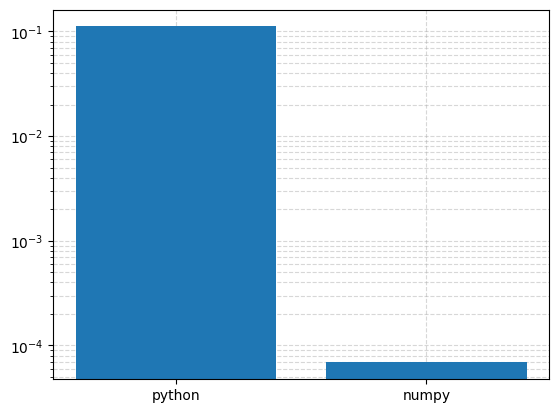

In [15]:
plot_times(['python', 'numpy'], [time_raw.average, time_np.average])

## Enters PyTorch

Now let's try with PyTorch. Note that PyTorch also uses a C-backend to implement linear algebra methods. However, it also has the power to run those operation on GPUs. Let's try both variants and compare them.

In [16]:
import torch

In [17]:
m1_pt = torch.from_numpy(m1_np)
m2_pt = torch.from_numpy(m2_np)

In [18]:
time_pt = %timeit -o m1_pt @ m2_pt

50.7 µs ± 601 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


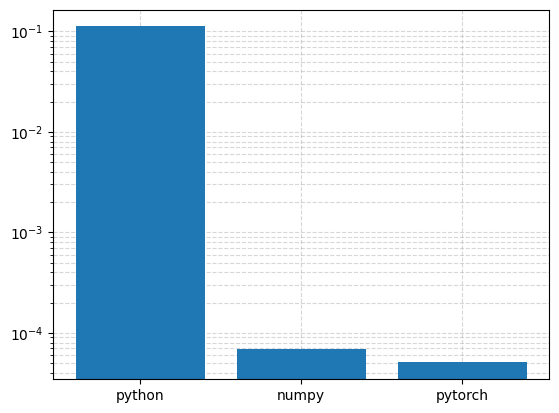

In [19]:
plot_times(['python', 'numpy', 'pytorch'], 
           [time_raw.average, time_np.average, time_pt.average])

Seems about the same... Now let's try to use a GPU:

In [20]:
m1_pt = m1_pt.to('cuda' if torch.cuda.is_available() else 'cpu')
m2_pt = m2_pt.to('cuda' if torch.cuda.is_available() else 'cpu')
time_pt_gpu = %timeit -o m1_pt @ m2_pt

22.9 µs ± 60.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


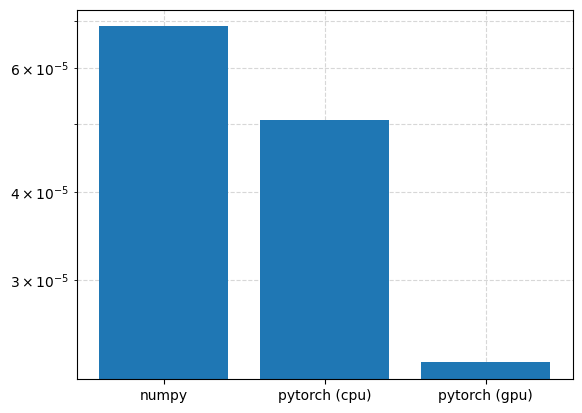

In [21]:
plot_times(['numpy', 'pytorch (cpu)', 'pytorch (gpu)'], 
           [time_np.average, time_pt.average, time_pt_gpu.average])

## Enters JIT

Now suppose we have an even more complicated function that contains control flows (if-else statements). To handle that, we have to rely on the Python interpreter, which is slow. To circumvent that, we can "compile" our function/module into a fixed intermediate-level code representation. 

https://pytorch.org/docs/stable/jit.html

22.9 µs ± 58.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


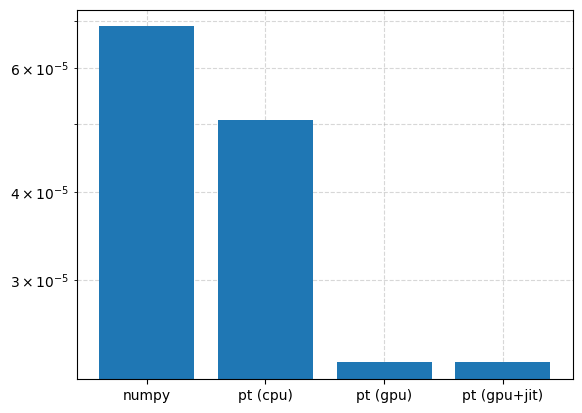

In [22]:
@torch.jit.script
def jit_mm(m1, m2):
    return m1 @ m2

time_pt_jit = %timeit -o jit_mm(m1_pt, m2_pt)

plot_times(['numpy', 'pt (cpu)', 'pt (gpu)', 'pt (gpu+jit)'], 
           [time_np.average, time_pt.average, time_pt_gpu.average, time_pt_jit.average])

For more optimizations, check this blog post by Horace He:
[Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html)